In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from itertools import permutations
from scipy.spatial import ConvexHull
from quadprog import solve_qp
from sklearn.metrics import accuracy_score


In [14]:
# Creating dataset 
centers = [[0, 1, 0], [1.5, 1.5, 1], [1, 1, 1]]
stds = [0.13, 0.12, 0.12] 

X, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)        
point_indices = np.arange(1000)

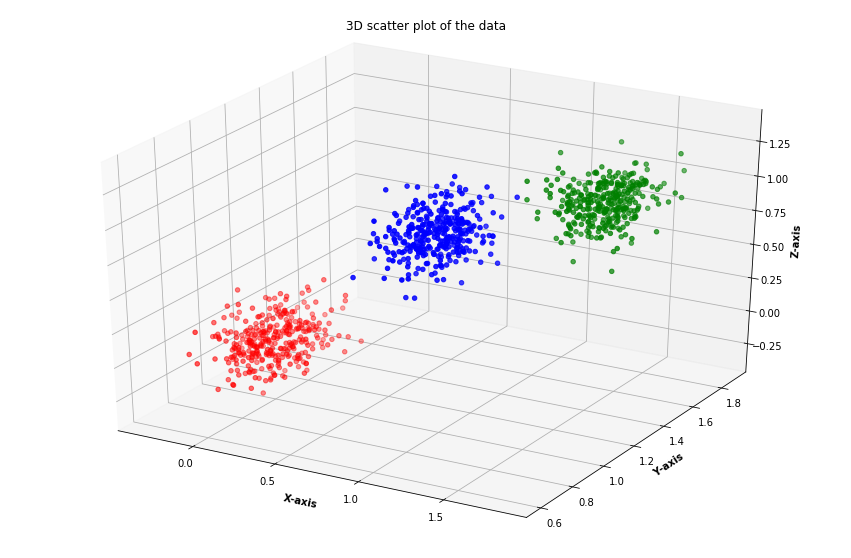

In [32]:
#Plot dataset
from mpl_toolkits.mplot3d import Axes3D
x = X[:,0]
y = X[:,1] 
z = X[:,2]

# Creating figure 
fig = plt.figure(figsize = (15, 10)) 
ax = plt.axes(projection ="3d") 
    
# Add gridlines  
ax.grid(b = True, color ='grey',  
        linestyle ='-.', linewidth = 0.3,  
        alpha = 0.2)  
  
mycolours = ["red", "green", "blue"]
# Creating color map 
col = [mycolours[i] for i in labels_true]
# Creating plot 
sctt = ax.scatter3D(x, y, z, c = col, marker ='o')
plt.title("3D scatter plot of the data\n") 
ax.set_xlabel('X-axis', fontweight ='bold')  
ax.set_ylabel('Y-axis', fontweight ='bold')  
ax.set_zlabel('Z-axis', fontweight ='bold')
  
# show plot 
plt.draw()

In [16]:
#get seeding and rest datasets
X_seeds, X_rest, y_seeds, y_rest, id_seeds, id_rest = train_test_split(X, labels_true, point_indices, test_size=0.33, random_state=42)

In [17]:
#remap clustering result to original labels
def remap_labels(pred_labels, true_labels):
    """Rename prediction labels (clustered output) to best match true labels."""
    # from itertools import permutations # import this into script.
    pred_labels, true_labels = np.array(pred_labels), np.array(true_labels)
    assert pred_labels.ndim == 1 == true_labels.ndim
    assert len(pred_labels) == len(true_labels)
    cluster_names = np.unique(pred_labels)
    accuracy = 0

    perms = np.array(list(permutations(np.unique(true_labels))))

    remapped_labels = true_labels
    for perm in perms:
        flipped_labels = np.zeros(len(true_labels))
        for label_index, label in enumerate(cluster_names):
            flipped_labels[pred_labels == label] = perm[label_index]

        testAcc = np.sum(flipped_labels == true_labels) / len(true_labels)
        if testAcc > accuracy:
            accuracy = testAcc
            remapped_labels = flipped_labels

    return accuracy, remapped_labels

In [18]:
#initial cluster using K-means
kmeans = KMeans(n_clusters=3, random_state=9).fit(X_seeds)
initial_result = kmeans.labels_

intial_accuracy, remapped_initial_result = remap_labels(initial_result, y_seeds)
print(intial_accuracy)


1.0


In [19]:
#get the indices of the datapoints belonging to each cluster
indices = {}

for i in range(len(id_seeds)):
    if int(remapped_initial_result[i]) not in indices:
        indices[int(remapped_initial_result[i])] = [i]
    else:
        indices[int(remapped_initial_result[i])].append(i)

# Get convex hulls for each cluster
hulls = {}

for i in indices:
    hull = ConvexHull(X_seeds[indices[i]])
    hulls[i] = hull

print(hulls.keys())

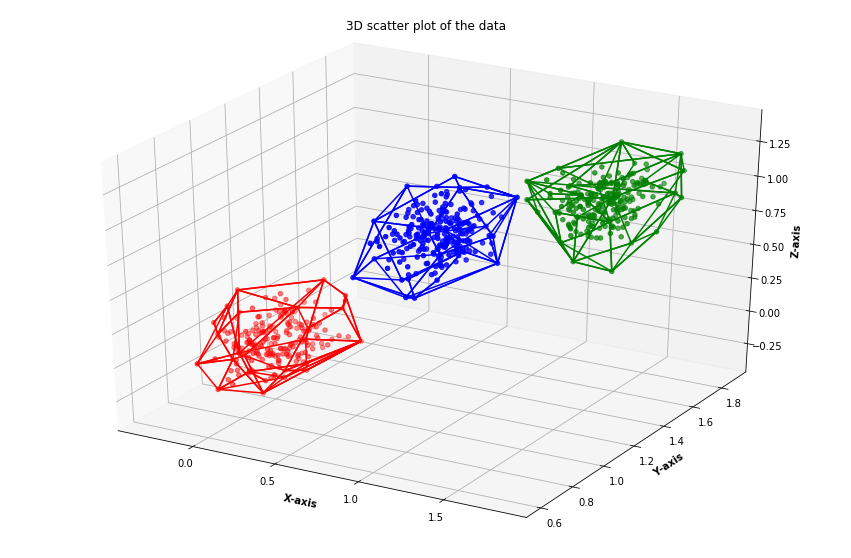

In [27]:
#plot the convex hulls
x = X_seeds[:,0]
y = X_seeds[:,1] 
z = X_seeds[:,2]
  
# Creating figure 
fig = plt.figure(figsize = (15, 10)) 
ax = plt.axes(projection ="3d") 
    
# Add gridlines  
ax.grid(b = True, color ='grey',  
        linestyle ='-.', linewidth = 0.3,  
        alpha = 0.2)  

col = [mycolours[i] for i in y_seeds]

# Creating plot 
sctt = ax.scatter3D(x, y, z, c = col, marker ='o') 

for i in indices:
    for simplex in hulls[i].simplices:
        ax.plot(X_seeds[indices[i]][simplex, 0], X_seeds[indices[i]][simplex, 1], X_seeds[indices[i]][simplex, 2], color=mycolours[i])

plt.title("3D scatter plot of the data\n") 
ax.set_xlabel('X-axis', fontweight ='bold')  
ax.set_ylabel('Y-axis', fontweight ='bold')  
ax.set_zlabel('Z-axis', fontweight ='bold') 
  
# show plot 
plt.draw()
plt.savefig('convex_hulls.png', dpi=300, bbox_inches="tight")        

In [28]:
#assign remaining points to the cluster convex hull
def point_in_hull(point, hull, tolerance=1e-12):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance) for eq in hull.equations)

def proj2hull(z, equations):
    """
    Project `z` to the convex hull defined by the
    hyperplane equations of the facets

    Arguments
        z: array, shape (ndim,)
        equations: array shape (nfacets, ndim + 1)

    Returns
        x: array, shape (ndim,)
    """
    G = np.eye(len(z), dtype=float)
    a = np.array(z, dtype=float)
    C = np.array(-equations[:, :-1], dtype=float)
    b = np.array(equations[:, -1], dtype=float)
    x, f, xu, itr, lag, act = solve_qp(G, a, C.T, b, meq=0, factorized=True)
    return x

In [29]:
prediction = []

for z1 in X_rest:
    
    min_cluster_distance = 100000
    min_distance_point = ""
    min_cluster_distance_hull = ""
    
    for i in indices:

        p = proj2hull(z1, hulls[i].equations)

        dist = np.linalg.norm(z1-p)

        if dist < min_cluster_distance:
            min_cluster_distance = dist
            min_distance_point = p
            min_cluster_distance_hull = i
            
    prediction.append(min_cluster_distance_hull)

prediction = np.array(prediction)

In [30]:
#evaluate result
Y_pred = np.concatenate((remapped_initial_result, prediction))
Y_real = np.concatenate((y_seeds, y_rest))

final_accuracy, remapped_final_result = remap_labels(Y_pred, Y_real)

print("Accuracy of Convex Hull method:", final_accuracy)

Accuracy of Convex Hull method: 1.0


In [31]:
accuracy_score(Y_real, Y_pred)

1.0

In [34]:
#run kmean on the entire dataset
kmeans = KMeans(n_clusters=3, random_state=9).fit(X)
result = kmeans.labels_

accuracy, remapped_result = remap_labels(result, labels_true)

print("Accuracy of K-means method:", accuracy)

Accuracy of K-means method: 1.0
